In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%matplotlib inline
sns.set(style="darkgrid", palette="muted", color_codes=True)

df = pd.read_csv('../data/input/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


- userid: ユーザ ID
- version: gate_30 ... 介入群、 gate_40 ... 対照群
- sum_gamerounds: インストール五の初週プレイラウンド数
- インストール後1日以内にプレイしたか
- インストール後7日以内にプレイしたか

In [2]:
# 欠損値の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
# retention_1 と retention_7 のクロス集計
pd.crosstab(df["retention_1"], df["retention_7"])

retention_7,False,True
retention_1,,
False,46437,3599
True,26971,13182


In [4]:
# 各グループの集計
df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


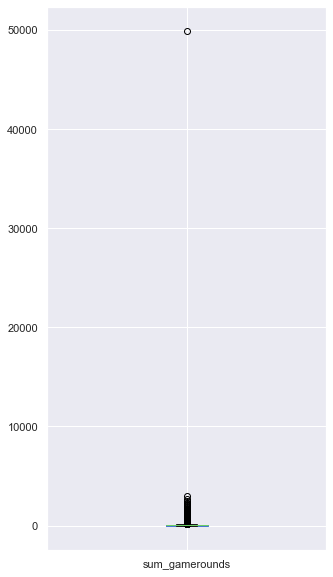

In [5]:
# 初週プレイ回数の箱ひげ図
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df['sum_gamerounds'].plot.box(figsize=(5,10), ax=ax)
plt.show()

In [6]:
# 初週プレイ回数の記述統計
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [7]:
# 初週プレイ回数の度数
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df.head(20)

sum_gamerounds
0     3994
1     5538
2     4606
3     3958
4     3629
5     2992
6     2861
7     2379
8     2267
9     2013
10    1752
11    1654
12    1570
13    1594
14    1519
15    1446
16    1342
17    1269
18    1228
19    1158
Name: userid, dtype: int64

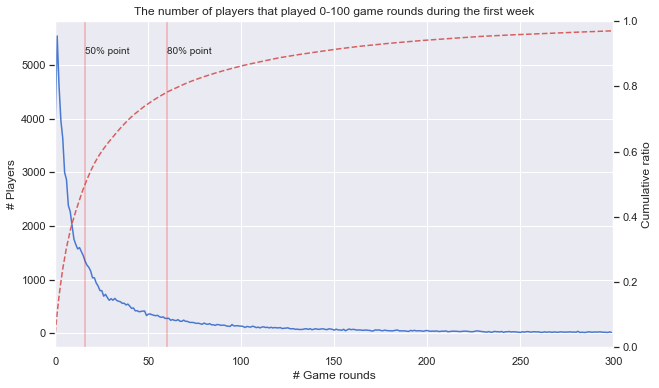

In [8]:
upper_rounds = 300

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plot_df_cumsum = plot_df.cumsum() / plot_df.sum()
plot_df[:upper_rounds].plot(figsize=(10,6), label="# Players", ax=ax)
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("# Players")
ax.set_xlabel("# Game rounds")

ax2 = ax.twinx()
ax2 = plot_df_cumsum[:upper_rounds].plot(ls="--", color="r", label="# Cumulative ratio")
ax2.vlines([16, 60], 0, 1, lw=.4, color="red", ls='solid')  # vline
ax2.grid(visible=False)
ax2.set_ylabel("Cumulative ratio")
ax2.set_xlim(0, upper_rounds)
ax2.set_ylim(0, 1)
ax2.text(16, .9, "50% point")
ax2.text(60, .9, "80% point")
plt.show()

- 右の裾が広いロングテール
- 約4000人のユーザが初週プレイ回数0回
- 約15000人のユーザが初週プレイ回数1~3回
- 50%のユーザが初週プレイ回数16回以下
- 80%のユーザが初週プレイ回数60回以下

In [9]:
# インストール後1日以内にプレイするユーザ割合
df['retention_1'].mean()

0.4452095044850259

In [10]:
# グループごとの、インストール後1日以内にプレイするユーザ割合
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [11]:
# グループごとに retention_1 をクロス集計
crossed_1d = pd.crosstab(df["version"], df["retention_1"])
crossed_1d

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [12]:
# chi2 検定
x2, p, dof, expected = stats.chi2_contingency(crossed_1d)

print("chi2： {}".format(x2))
print("p-value: {}".format(p))
print("degree of freedom: {}".format(dof))
if p < 0.01:
    print("-> Significant differences")
else:
    print("-> No significant difference")

chi2： 3.1591007878782262
p-value: 0.07550476210309086
degree of freedom: 1
-> No significant difference


In [13]:
# グループごとに retention_7 をクロス集計
crossed_7d = pd.crosstab(df["version"], df["retention_7"])
print(crossed_7d)

retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279


In [14]:
# chi2 検定
x2, p, dof, expected = stats.chi2_contingency(crossed_7d)

print("chi2： {}".format(x2))
print("p-value: {}".format(p))
print("degree of freedom: {}".format(dof))
if p < 0.01:
    print("-> Significant differences")
else:
    print("-> No significant difference")

chi2： 9.959086799559167
p-value: 0.0016005742679058301
degree of freedom: 1
-> Significant differences


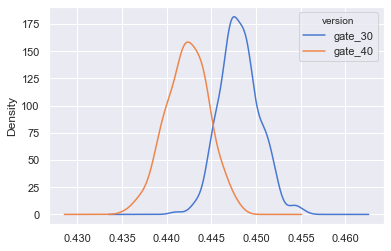

In [15]:
# Bootstrap method
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
boot_1d.plot(kind="density", ax=ax)
plt.show()

Probability that 1-day retention is greater when the gate is at level 30: 0.962


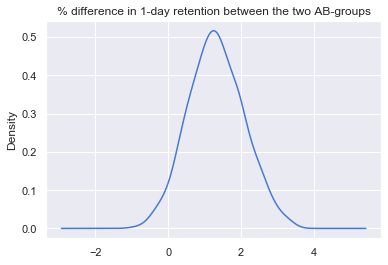

In [16]:
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

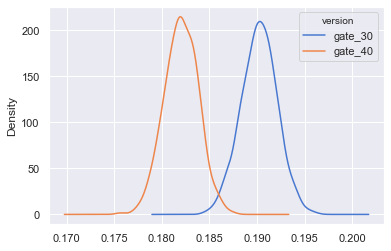

In [17]:
# Boottrap method
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
boot_7d.plot(kind="density", ax=ax)
plt.show()

Probability that 7-day retention is greater when the gate is at level 30: 1.0


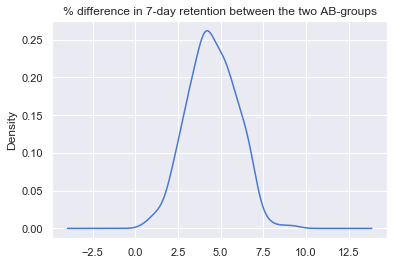

In [18]:
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())